In [1]:
!pip install seaborn 

You should consider upgrading via the 'C:\Users\vdalal\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd

# Load data
youth_data = pd.read_csv('https://media.githubusercontent.com/media/mendible/5322/main/Homework%201/youth_data.csv')

# Substance columns
substance_cols = [
    'iralcfy', 'irmjfy', 'ircigfm', 'IRSMKLSS30N', 'iralcfm', 'irmjfm',
    'ircigage', 'irsmklsstry', 'iralcage', 'irmjage',
    'mrjflag', 'alcflag', 'tobflag',
    'alcydays', 'mrjydays', 'alcmdays', 'mrjmdays', 'cigmdays', 'smklsmdays'
]

# Demographic columns
demographic_cols = [
    'irsex', 'NEWRACE2', 'HEALTH2', 'eduschlgo', 'EDUSCHGRD2', 'eduskpcom',
    'imother', 'ifather', 'income', 'govtprog', 'POVERTY3', 'PDEN10', 'COUTYP4'
]

# Select columns
df_youth = youth_data.loc[:, 'schfelt':'rlgfrnd']
df_substance = youth_data[substance_cols]
df_demog = youth_data[demographic_cols]

# Combine dataframes
df = pd.concat([df_substance, df_youth, df_demog], axis=1)

# Convert to categorical variables
unordered_factor_cols = list(df_youth.columns) + ['mrjflag', 'alcflag', 'tobflag', 'irsex', 'NEWRACE2', 'eduschlgo', 'imother', 'ifather', 'govtprog', 'PDEN10', 'COUTYP4']
ordered_factor_cols = ['EDUSCHGRD2', 'HEALTH2', 'POVERTY3', 'income']

df[unordered_factor_cols] = df[unordered_factor_cols].astype('category')
df[ordered_factor_cols] = df[ordered_factor_cols].apply(lambda x: pd.Categorical(x, ordered=True))

# Cleaning the demographic variables
df = df[~df['EDUSCHGRD2'].isin([98, 99])]
df = df[~df['eduskpcom'].isin([94, 97, 98, 99])]
df = df[~df['imother'].isin([3, 4])]
df = df[~df['ifather'].isin([3, 4])]
df = df[df['PDEN10'] != 3]

# Reset index
df.reset_index(drop=True, inplace=True)
# Check dimensions
print(df.shape)

(4032, 79)


## Method 1 : Binary Classification

#### Decision Tree

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Select relevant columns
df_demog = df[demographic_cols]
df_youth = df.loc[:, 'schfelt':'rlgfrnd']  # Assuming SCHFELT to RLGFRND are the column names
MRJFLAG = df['mrjflag']

# Concatenate the selected data frames horizontally (by columns)
data = pd.concat([df_demog, df_youth, MRJFLAG], axis=1)

# Print the dimensions of the resulting dataset
print(data.shape)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=5)

# Build a decision tree model on the training data
X_train = train_data.drop(columns=['mrjflag'])
y_train = train_data['mrjflag']
decision_model = DecisionTreeClassifier(random_state=1)
decision_model
decision_model.fit(X_train, y_train)

# Predict on test data
X_test = test_data.drop(columns=['mrjflag'])
y_test = test_data['mrjflag']
predictions = decision_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test_data['mrjflag'], predictions)
print("Accuracy:", accuracy)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(test_data['mrjflag'], predictions)
print("Confusion Matrix:")
print(conf_matrix)


# Calculate Mean Squared Error (MSE)
decison_mse = ((predictions != test_data['mrjflag']) ** 2).mean()
print("Mean Squared Error (MSE):", decison_mse)

importances = decision_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print("Feature Importances:")
print(feature_importance_df.head(10))

(4032, 61)
Accuracy: 0.8628099173553719
Confusion Matrix:
[[959  84]
 [ 82  85]]
Mean Squared Error (MSE): 0.1371900826446281
Feature Importances:
      Feature  Importance
0     yflmjmo    0.238458
1     stndsmj    0.104704
2    PRMJEVR2    0.037032
3    NEWRACE2    0.032670
4  EDUSCHGRD2    0.029250
5     HEALTH2    0.028165
6     PRTALK3    0.027764
7   eduskpcom    0.026174
8    parchkhw    0.019796
9       irsex    0.018836


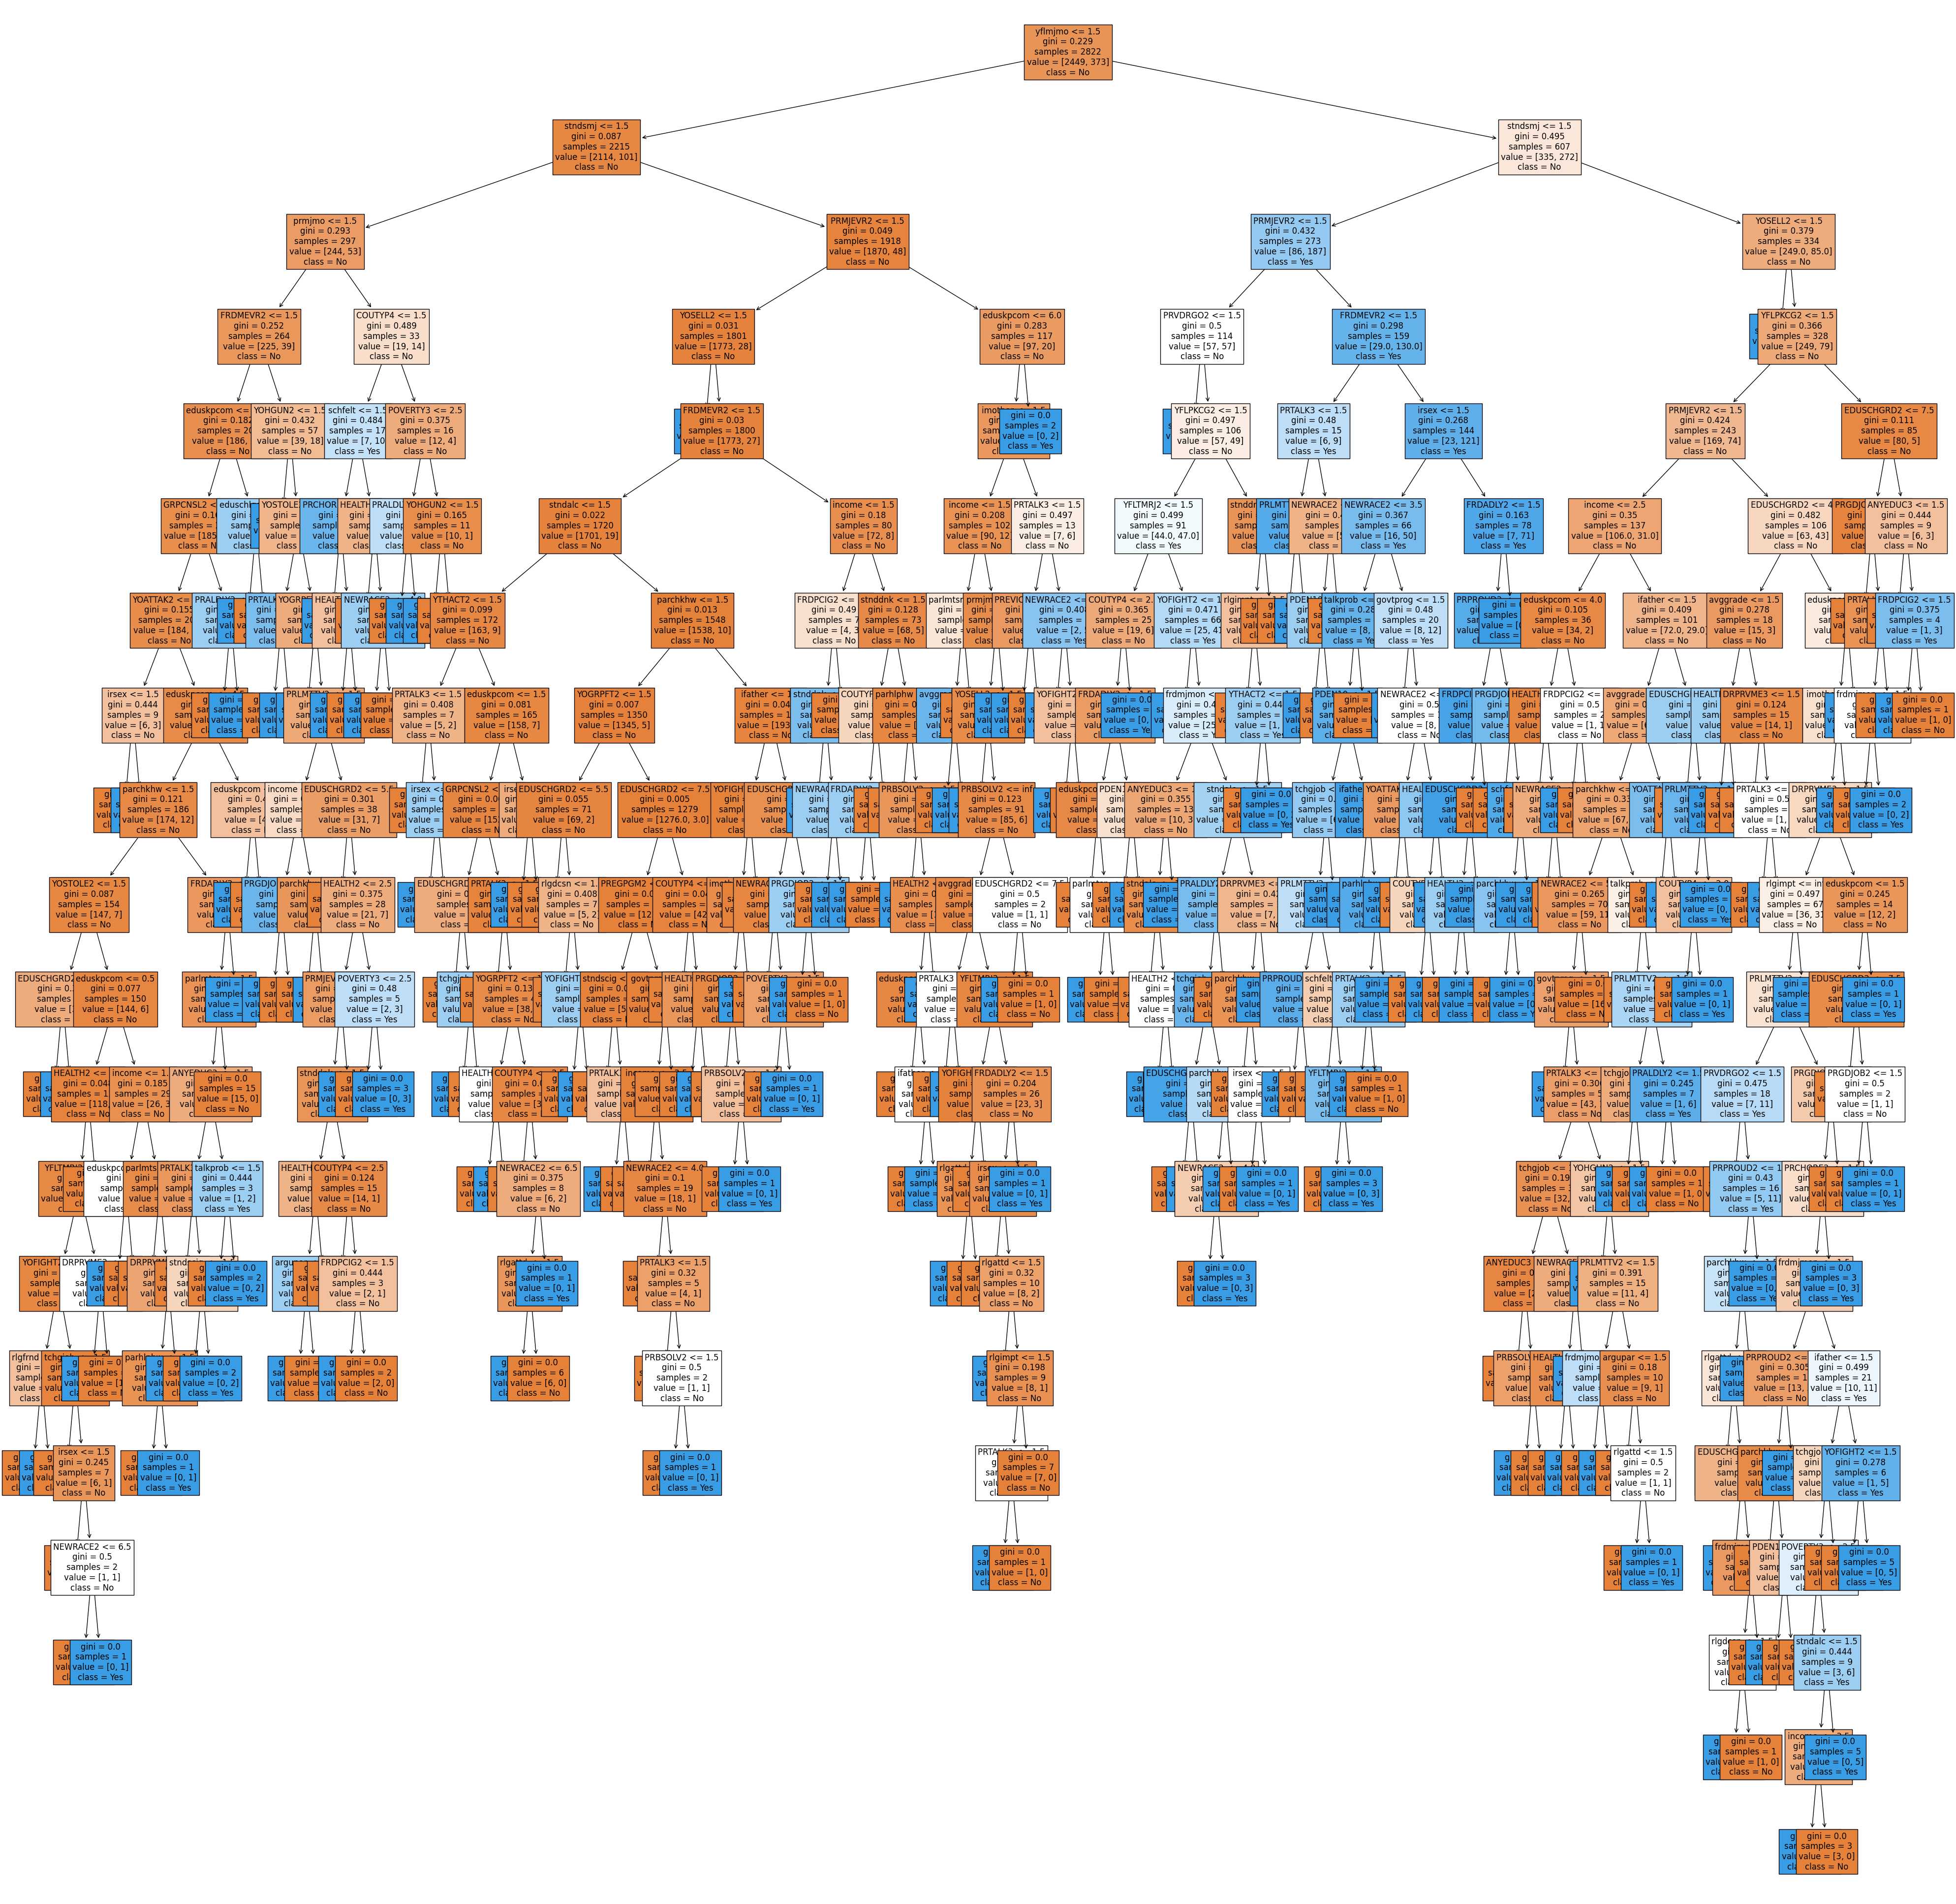

In [4]:
# Plot decision tree
plt.figure(figsize=(50,50))
plot_tree(decision_model, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True,fontsize=12)
plt.show()

### Prunning:

Best Parameters: {'max_leaf_nodes': 10}
MSE: 0.10082644628099173
Confusion Matrix:
[[1029   14]
 [ 108   59]]


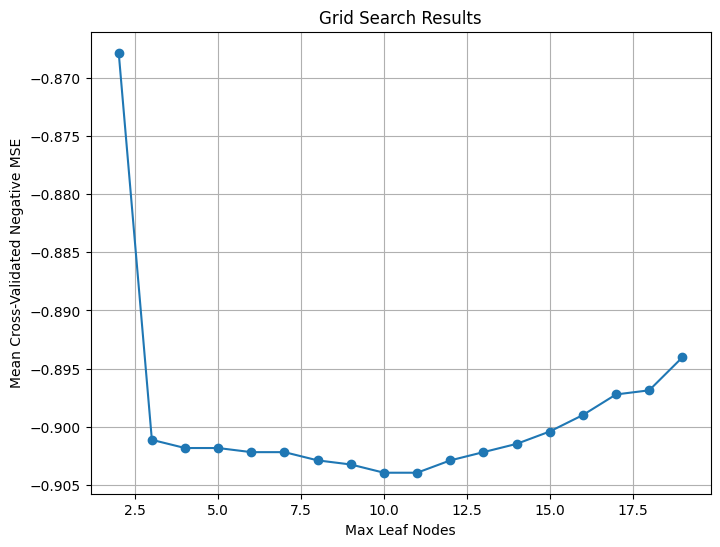

Top 5 Features:
    Feature  Importance
0   yflmjmo    0.584661
1   stndsmj    0.256716
2  PRMJEVR2    0.070826
3  YFLPKCG2    0.028795
4   YOSELL2    0.025721


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,mean_squared_error

# Define parameter grid
param_grid = {'max_leaf_nodes': range(2, 20)}  

# Initialize DecisionTreeClassifier
decision_model = DecisionTreeClassifier(random_state=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=decision_model, param_grid=param_grid)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_decision_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict on test data using best model
best_predictions = best_decision_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
best_mse = ((best_predictions != test_data['mrjflag']) ** 2).mean()
print("MSE:", best_mse)

# Generate Confusion Matrix for best model
best_conf_matrix = confusion_matrix(test_data['mrjflag'], best_predictions)
print("Confusion Matrix:")
print(best_conf_matrix)

# Extract grid search results
results = grid_search.cv_results_
leaf_nodes = results['param_max_leaf_nodes']
neg_mse = -results['mean_test_score']

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(leaf_nodes, neg_mse, marker='o', linestyle='-')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Mean Cross-Validated Negative MSE')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()

feature_importances = best_decision_model.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False,)
importance_df.reset_index(drop=True, inplace=True)
# Print the top 10 features
print("Top 5 Features:")
print(importance_df.head(5))

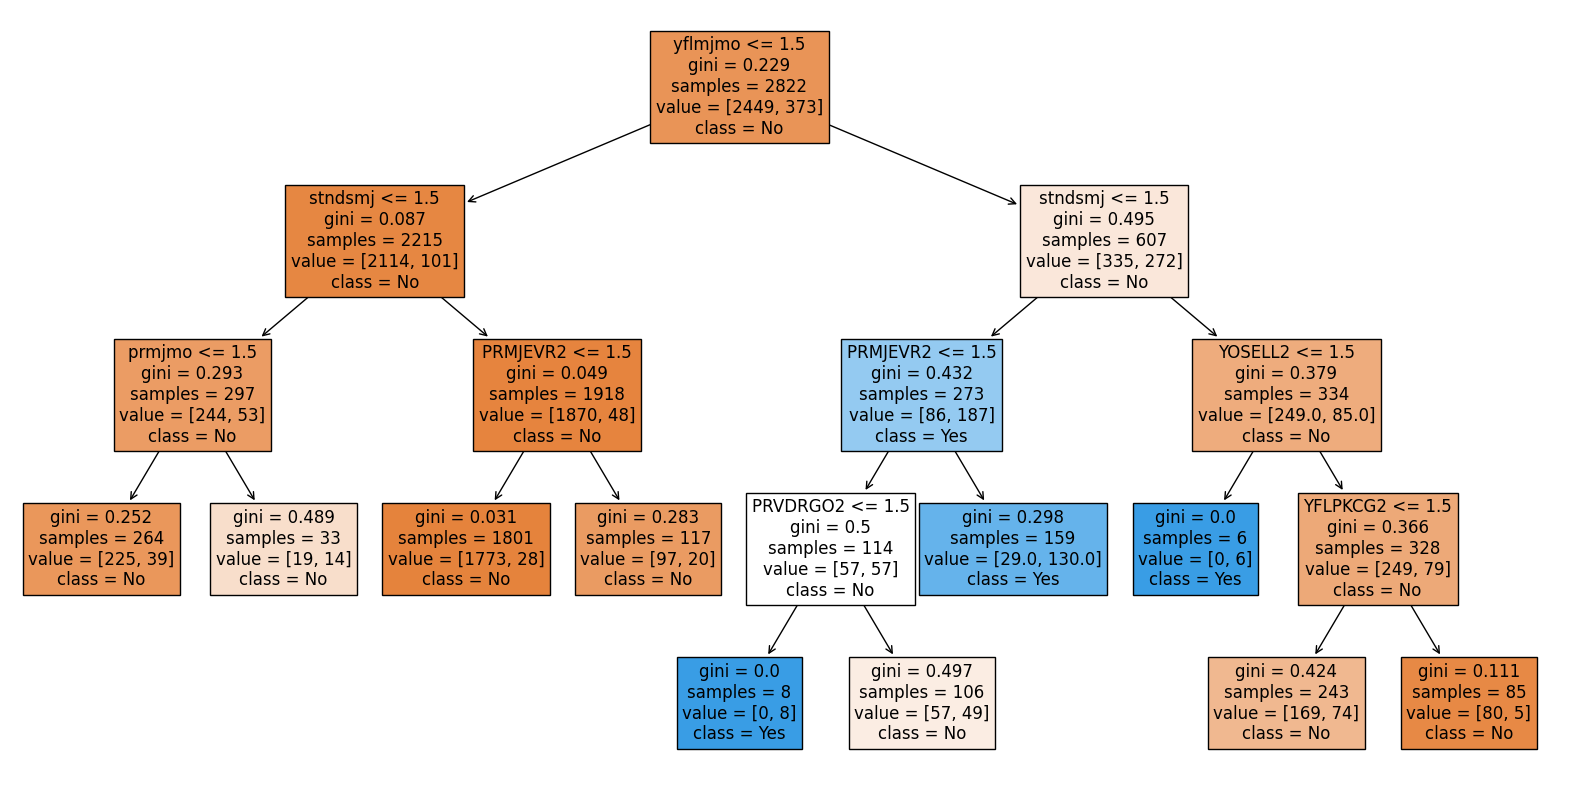

In [6]:
# Plot decision tree
plt.figure(figsize=(20,10))
plot_tree(best_decision_model, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True,fontsize=12)
plt.show()

### Random Forest:

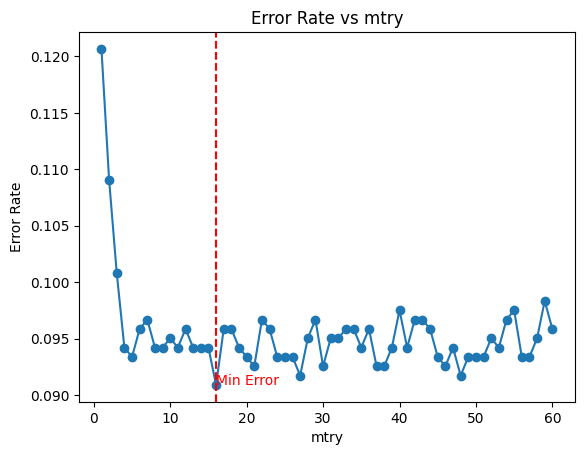

Best value of mtry: 16 has the error rate of: 0.09
Mean Squared Error (MSE): 0.09090909090909091
Confusion Matrix:
[[1022   21]
 [  89   78]]


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set the seed for reproducibility
np.random.seed(5)

# Perform bagging with random forest for different values of mtry
p = range(1, X_train.shape[1] + 1)
error = []

for i in p:
    # Fit the random forest model with current mtry value
    bagging_rf_model = RandomForestClassifier(n_estimators=500, max_features=i, random_state=5)
    bagging_rf_model.fit(X_train, y_train)
  
    # Predict on test data using bagging model
    bagging_rf_predictions = bagging_rf_model.predict(X_test)
  
    # Calculate error rate
    error_rate = np.mean(bagging_rf_predictions != y_test)
    error.append(error_rate)

# Plot the error rate for different values of mtry
plt.plot(p, error, marker='o')
plt.xlabel('mtry')
plt.ylabel('Error Rate')
plt.title('Error Rate vs mtry')
index = np.argmin(np.round(error, 3)) # Index of the minimum error rate
Min_error = error[index]
min_p = p[index]
plt.axvline(x=min_p, color='red', linestyle='--')
plt.text(min_p, Min_error, "Min Error", color='red')
plt.show()

best_mtry = min_p
print("Best value of mtry:", best_mtry, "has the error rate of:", round(Min_error, 2))

# Fit the random forest model with the best mtry value
bagging_rf_model = RandomForestClassifier(n_estimators=500, max_features=int(best_mtry), random_state=5)
bagging_rf_model.fit(X_train, y_train)

# Predict on test data using bagging model
bagging_rf_predictions = bagging_rf_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, bagging_rf_predictions)
print("Mean Squared Error (MSE):", mse)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, bagging_rf_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Get feature importances
feature_importances = bagging_rf_model.feature_importances_

# Get the indices of the top 10 features
top_10_indices = np.argsort(feature_importances)[::-1][:10]

# Get the names and importances of the top 10 features
top_10_features = [X_train.columns[idx] for idx in top_10_indices]
top_10_importances = feature_importances[top_10_indices]


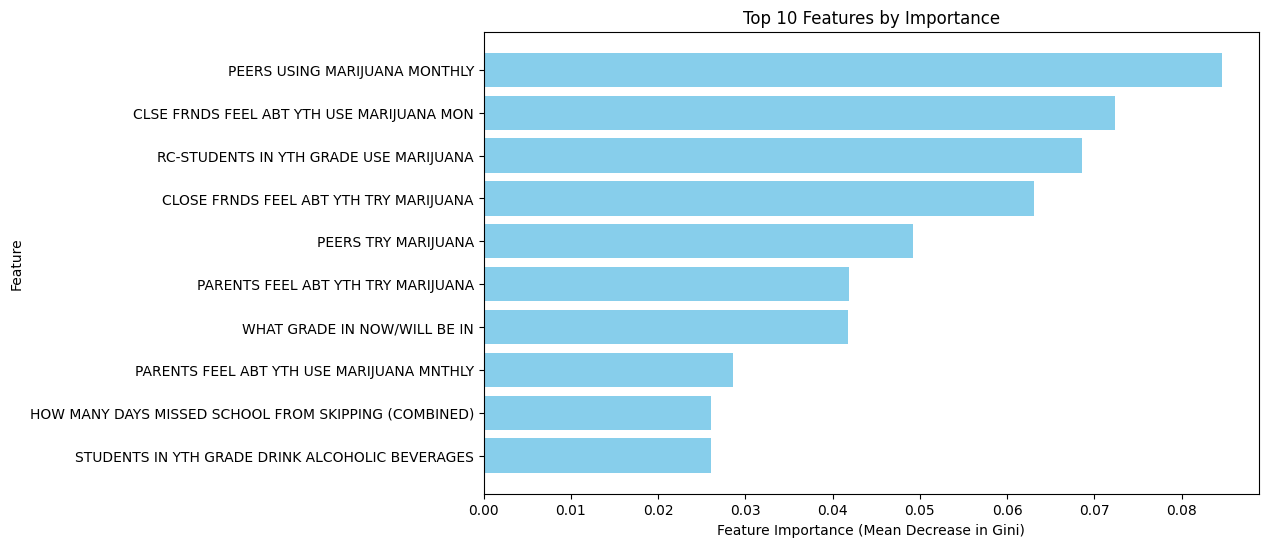

In [8]:
feature_name_mapping = {
    'yflmjmo': 'PEERS USING MARIJUANA MONTHLY',
    'frdmjmon': 'CLSE FRNDS FEEL ABT YTH USE MARIJUANA MON',
    'stndsmj': 'RC-STUDENTS IN YTH GRADE USE MARIJUANA',
    'FRDMEVR2': 'CLOSE FRNDS FEEL ABT YTH TRY MARIJUANA',
    'YFLTMRJ2': 'PEERS TRY MARIJUANA',
    'PRMJEVR2': 'PARENTS FEEL ABT YTH TRY MARIJUANA',
    'EDUSCHGRD2': 'WHAT GRADE IN NOW/WILL BE IN',
    'prmjmo': 'PARENTS FEEL ABT YTH USE MARIJUANA MNTHLY',
    'eduskpcom': 'HOW MANY DAYS MISSED SCHOOL FROM SKIPPING (COMBINED)',
    'stndalc': 'STUDENTS IN YTH GRADE DRINK ALCOHOLIC BEVERAGES'
}

# Convert the original feature names to their descriptive equivalents
readable_features = [feature_name_mapping[f] for f in top_10_features]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(readable_features, top_10_importances, color='skyblue')
plt.xlabel('Feature Importance (Mean Decrease in Gini)')
plt.ylabel('Feature')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

### Bagging

Bagging Accuracy: 0.9041322314049587
Bagging MSE: 0.09586776859504133
Confusion Matrix:
[[1014   29]
 [  87   80]]
Top 10 Feature Importances:
      Feature  Importance
0     yflmjmo    0.141436
1     stndsmj    0.090034
2    frdmjmon    0.084974
3    FRDMEVR2    0.043517
4  EDUSCHGRD2    0.038543
5    PRMJEVR2    0.033554
6   eduskpcom    0.028785
7    YFLTMRJ2    0.028649
8     HEALTH2    0.023673
9    NEWRACE2    0.023315


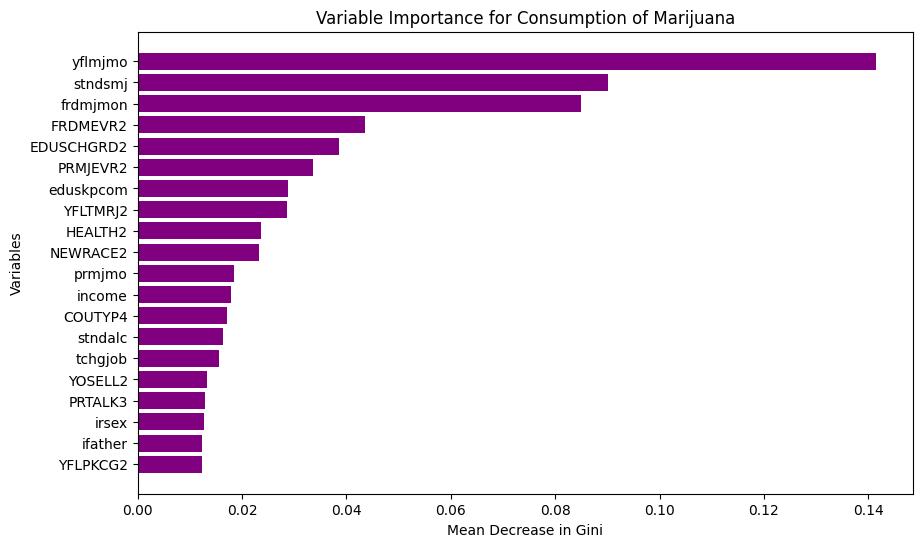

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Set the seed for reproducibility
import numpy as np
np.random.seed(5)

# Define the number of variables to sample at each split
mtry_value = train_data.shape[1] - 1

# Perform bagging with random forest using mtry
bagging_model = RandomForestClassifier(n_estimators=500, max_features=mtry_value, random_state=5)
bagging_model.fit(train_data.drop(columns=['mrjflag']), train_data['mrjflag'])

# Predict on test data using bagging model
bagging_predictions = bagging_model.predict(test_data.drop(columns=['mrjflag']))

# Calculate accuracy
bagging_accuracy = accuracy_score(test_data['mrjflag'], bagging_predictions)

# Calculate Mean Squared Error (MSE)
bagging_mse = mean_squared_error(test_data['mrjflag'], bagging_predictions)

# Print accuracy
print("Bagging Accuracy:", bagging_accuracy)

# Print MSE
print("Bagging MSE:", bagging_mse)

# Generate Confusion Matrix for bagging model
bagging_conf_matrix = confusion_matrix(test_data['mrjflag'], bagging_predictions)
print("Confusion Matrix:")
print(bagging_conf_matrix)

# Extract feature importances from the bagging model
importances = bagging_model.feature_importances_
feature_names = train_data.drop(columns=['mrjflag']).columns

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print top 10 feature importances
print("Top 10 Feature Importances:")
print(importance_df.head(10))

# Plot variable importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='purple')
plt.xlabel('Mean Decrease in Gini')
plt.ylabel('Variables')
plt.title('Variable Importance for Consumption of Marijuana')
plt.gca().invert_yaxis()
plt.show()


### Gradient - Boosting

Best shrinkage value: 0.1


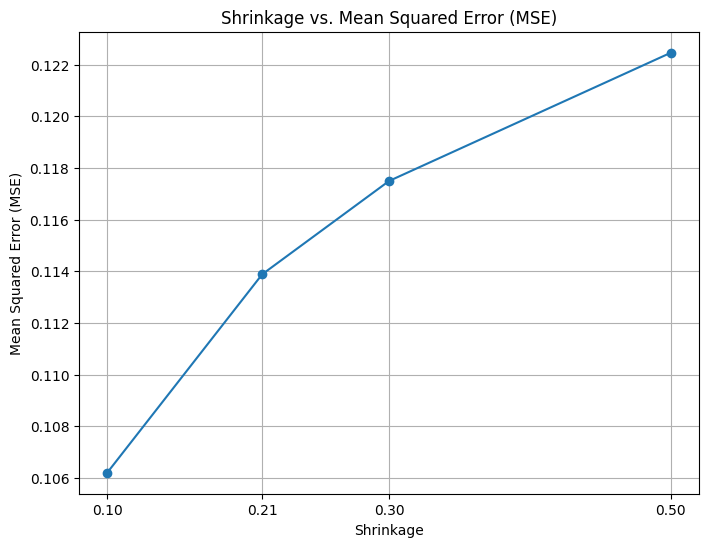

Best model MSE: 0.10471204188481675
Confusion Matrix for best model:
[[776  34]
 [ 66  79]]
Top 10 Feature Importance:
      Feature  Importance
0     yflmjmo    0.209413
1     stndsmj    0.135697
2    frdmjmon    0.103034
3    YFLTMRJ2    0.083561
4    FRDMEVR2    0.064700
5    PRMJEVR2    0.049040
6  EDUSCHGRD2    0.026885
7   eduskpcom    0.020952
8    YFLPKCG2    0.020749
9    FRDPCIG2    0.020379


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.impute import SimpleImputer
import pandas as pd

# Remove missing values from train and test data
train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

# Define a list of shrinkage values to try
shrinkage_values = [0.1, 0.21, 0.3,0.5]

# Initialize lists to store results
mse_scores = []
confusion_matrices = []

# Iterate over shrinkage values
for shrinkage in shrinkage_values:
    # Train Gradient Boosting model with current shrinkage value
    gb_model = GradientBoostingClassifier(learning_rate=shrinkage, n_estimators=100, subsample=0.8, max_depth=3, random_state=123)
    
    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(gb_model, train_data_clean.drop(columns=['mrjflag']), train_data_clean['mrjflag'], cv=5, scoring='neg_mean_squared_error')
    mse_scores.append((-1) * cv_scores.mean())  # Take the negative mean squared error
    
    # Fit the model on the entire training data
    gb_model.fit(train_data_clean.drop(columns=['mrjflag']), train_data_clean['mrjflag'])
    
    # Make predictions on the test data
    test_preds = gb_model.predict(test_data_clean.drop(columns=['mrjflag']))
    
    # Calculate confusion matrix
    confusion_matrices.append(confusion_matrix(test_data_clean['mrjflag'], test_preds))

# Select the best shrinkage value based on MSE
best_shrinkage_idx = mse_scores.index(min(mse_scores))
best_shrinkage = shrinkage_values[best_shrinkage_idx]
print("Best shrinkage value:", best_shrinkage)

plt.figure(figsize=(8, 6))
plt.plot(shrinkage_values, mse_scores, marker='o', linestyle='-')
plt.title('Shrinkage vs. Mean Squared Error (MSE)')
plt.xlabel('Shrinkage')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(shrinkage_values)
plt.grid(True)
plt.show()


# Train the Gradient Boosting model with the best shrinkage value
best_gb_model = GradientBoostingClassifier(learning_rate=best_shrinkage, n_estimators=100, subsample=0.8, max_depth=3, random_state=123)
best_gb_model.fit(train_data_clean.drop(columns=['mrjflag']), train_data_clean['mrjflag'])

# Make predictions on the test data
test_preds = best_gb_model.predict(test_data_clean.drop(columns=['mrjflag']))

# Calculate Mean Squared Error (MSE)
best_gb_mse = mean_squared_error(test_data_clean['mrjflag'], test_preds)
print("Best model MSE:", best_gb_mse)

# Generate Confusion Matrix for best model
best_conf_matrix = confusion_matrix(test_data_clean['mrjflag'], test_preds)
print("Confusion Matrix for best model:")
print(best_conf_matrix)

# Extract feature importance
feature_importance = pd.DataFrame({'Feature': train_data_clean.drop(columns=['mrjflag']).columns,
                                   'Importance': best_gb_model.feature_importances_})
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True).head(10)
print("Top 10 Feature Importance:")
print(top_10_features)

#### Comparison Plot:

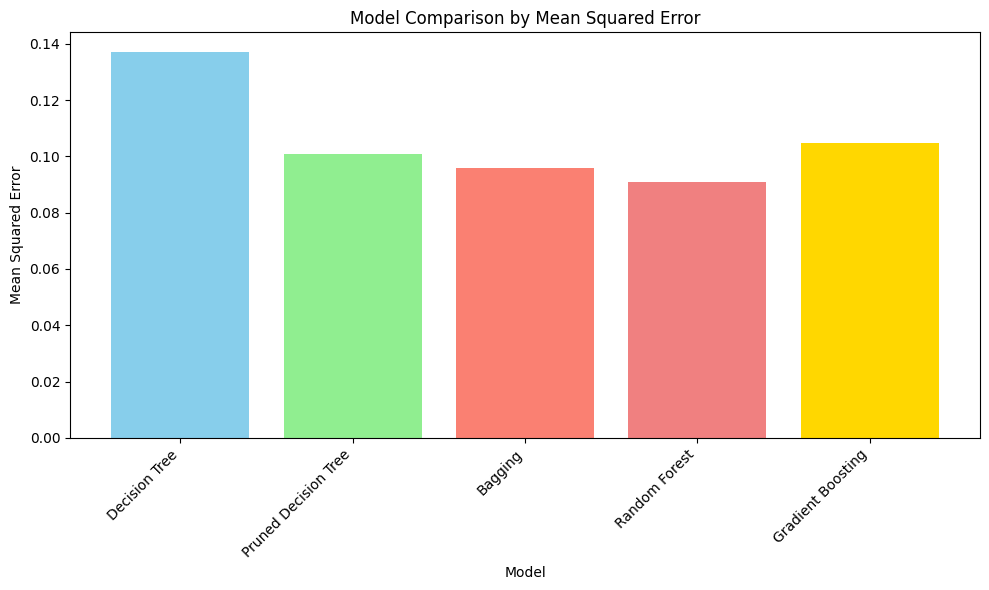

In [11]:
# Define Mean Squared Errors for all models
MSE_values = [decison_mse, best_mse, bagging_mse, mse, best_gb_mse]

# Define model names
model_names = ["Decision Tree", "Pruned Decision Tree", "Bagging", "Random Forest", "Gradient Boosting"]

colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold']

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(model_names, MSE_values, color=colors)
plt.title('Model Comparison by Mean Squared Error')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Method 2: Multiclass Classification

In [12]:
import pandas as pd

# Select relevant columns
df_demog = df[demographic_cols]
df_youth = df.loc[:, 'schfelt':'rlgfrnd']  # Assuming SCHFELT to RLGFRND are the column names
mrjydays = df['mrjydays']

# Concatenate the selected data frames horizontally (by columns)
mrjydays_data = pd.concat([df_demog, df_youth, mrjydays], axis=1)
mrjydays_data= mrjydays_data.dropna()

# Print the dimensions of the resulting dataset
print(mrjydays_data.shape)
mrjydays_data

(3168, 61)


irsex NEWRACE2 HEALTH2 eduschlgo EDUSCHGRD2  eduskpcom imother ifather  \
0        1        1     3.0         1          5          0       1       1   
1        1        1     2.0         1          5          0       1       1   
2        1        5     2.0         1          4          0       1       1   
3        2        5     1.0         1          7          0       1       1   
5        1        6     2.0         1          8          0       1       2   
...    ...      ...     ...       ...        ...        ...     ...     ...   
4027     2        1     2.0         1          7          0       1       1   
4028     1        1     1.0         1          6          0       1       1   
4029     1        5     2.0         1          5          0       1       1   
4030     1        7     2.0         1          7          0       2       2   
4031     2        5     1.0         1          3          0       1       1   

     income govtprog  ... GRPCNSL2 PREGPGM2 YTHACT2 DRPRVME3 ANYEDUC3 rlgattd  \
0         4        2  ...      2.0      2.0     2.0      1.0      1.0     2.0   
1         4        2  ...      2.0      1.0     2.0      1.0      1.0     2.0   
2         4        1  ...      2.0      2.0     2.0      1.0      1.0     2.0   
3         2        2  ...      2.0      2.0     2.0      1.0      1.0     2.0   
5         4        2  ...      2.0      2.0     2.0      1.0      2.0     2.0   
...     ...      ...  ...      ...      ...     ...      ...      ...     ...   
4027      4        2  ...      2.0      2.0     2.0      1.0      2.0     2.0   
4028      4        2  ...      2.0      2.0     2.0      2.0      1.0     2.0   
4029      4        2  ...      2.0      2.0     2.0      1.0      1.0     2.0   
4030      3        2  ...      2.0      2.0     2.0      1.0      1.0     2.0   
4031      3        2  ...      2.0      2.0     1.0      2.0      2.0     2.0   

     rlgimpt rlgdcsn rlgfrnd mrjydays  
0        2.0     2.0     2.0        6  
1        2.0     2.0     2.0        6  
2        1.0     1.0     1.0        6  
3        1.0     1.0     2.0        6  
5        2.0     2.0     2.0        6  
...      ...     ...     ...      ...  
4027     2.0     2.0     2.0        6  
4028     1.0     2.0     2.0        6  
4029     2.0     2.0     2.0        6  
4030     2.0     2.0     2.0        6  
4031     1.0     1.0     1.0        6  

[3168 rows x 61 columns]

In [13]:
X = mrjydays_data.drop(columns=['mrjydays'])
y = mrjydays_data['mrjydays']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [14]:
# Train the DecisionTreeClassifier model
decision_model1 = DecisionTreeClassifier(random_state=5)
decision_model1.fit(X_train, y_train)

# Calculate feature importance
feature_importance = decision_model1.feature_importances_

# Predict on test data
predictions1 = decision_model1.predict(X_test)

accuracy = accuracy_score(y_test, predictions1)
print("Accuracy:", accuracy)

# Calculate test error
decision_test_error = 1 - accuracy
print("Test Error:", decision_test_error)

# Print feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
top_10_features = X.columns[sorted_indices][:10]
print("Top 10 Features and their Importance Scores:")
for feature, importance in zip(top_10_features, feature_importance[sorted_indices][:10]):
    print(feature, ":", importance)


Accuracy: 0.832807570977918
Test Error: 0.16719242902208198
Top 10 Features and their Importance Scores:
yflmjmo : 0.15791566978142416
stndsmj : 0.06677482486154422
EDUSCHGRD2 : 0.05655819455728069
eduskpcom : 0.054014806178822886
NEWRACE2 : 0.03542368084642042
income : 0.028355328334560597
frdmjmon : 0.025922198027854004
rlgimpt : 0.02349000777628002
HEALTH2 : 0.022833792280914953
stndalc : 0.022019650766097486


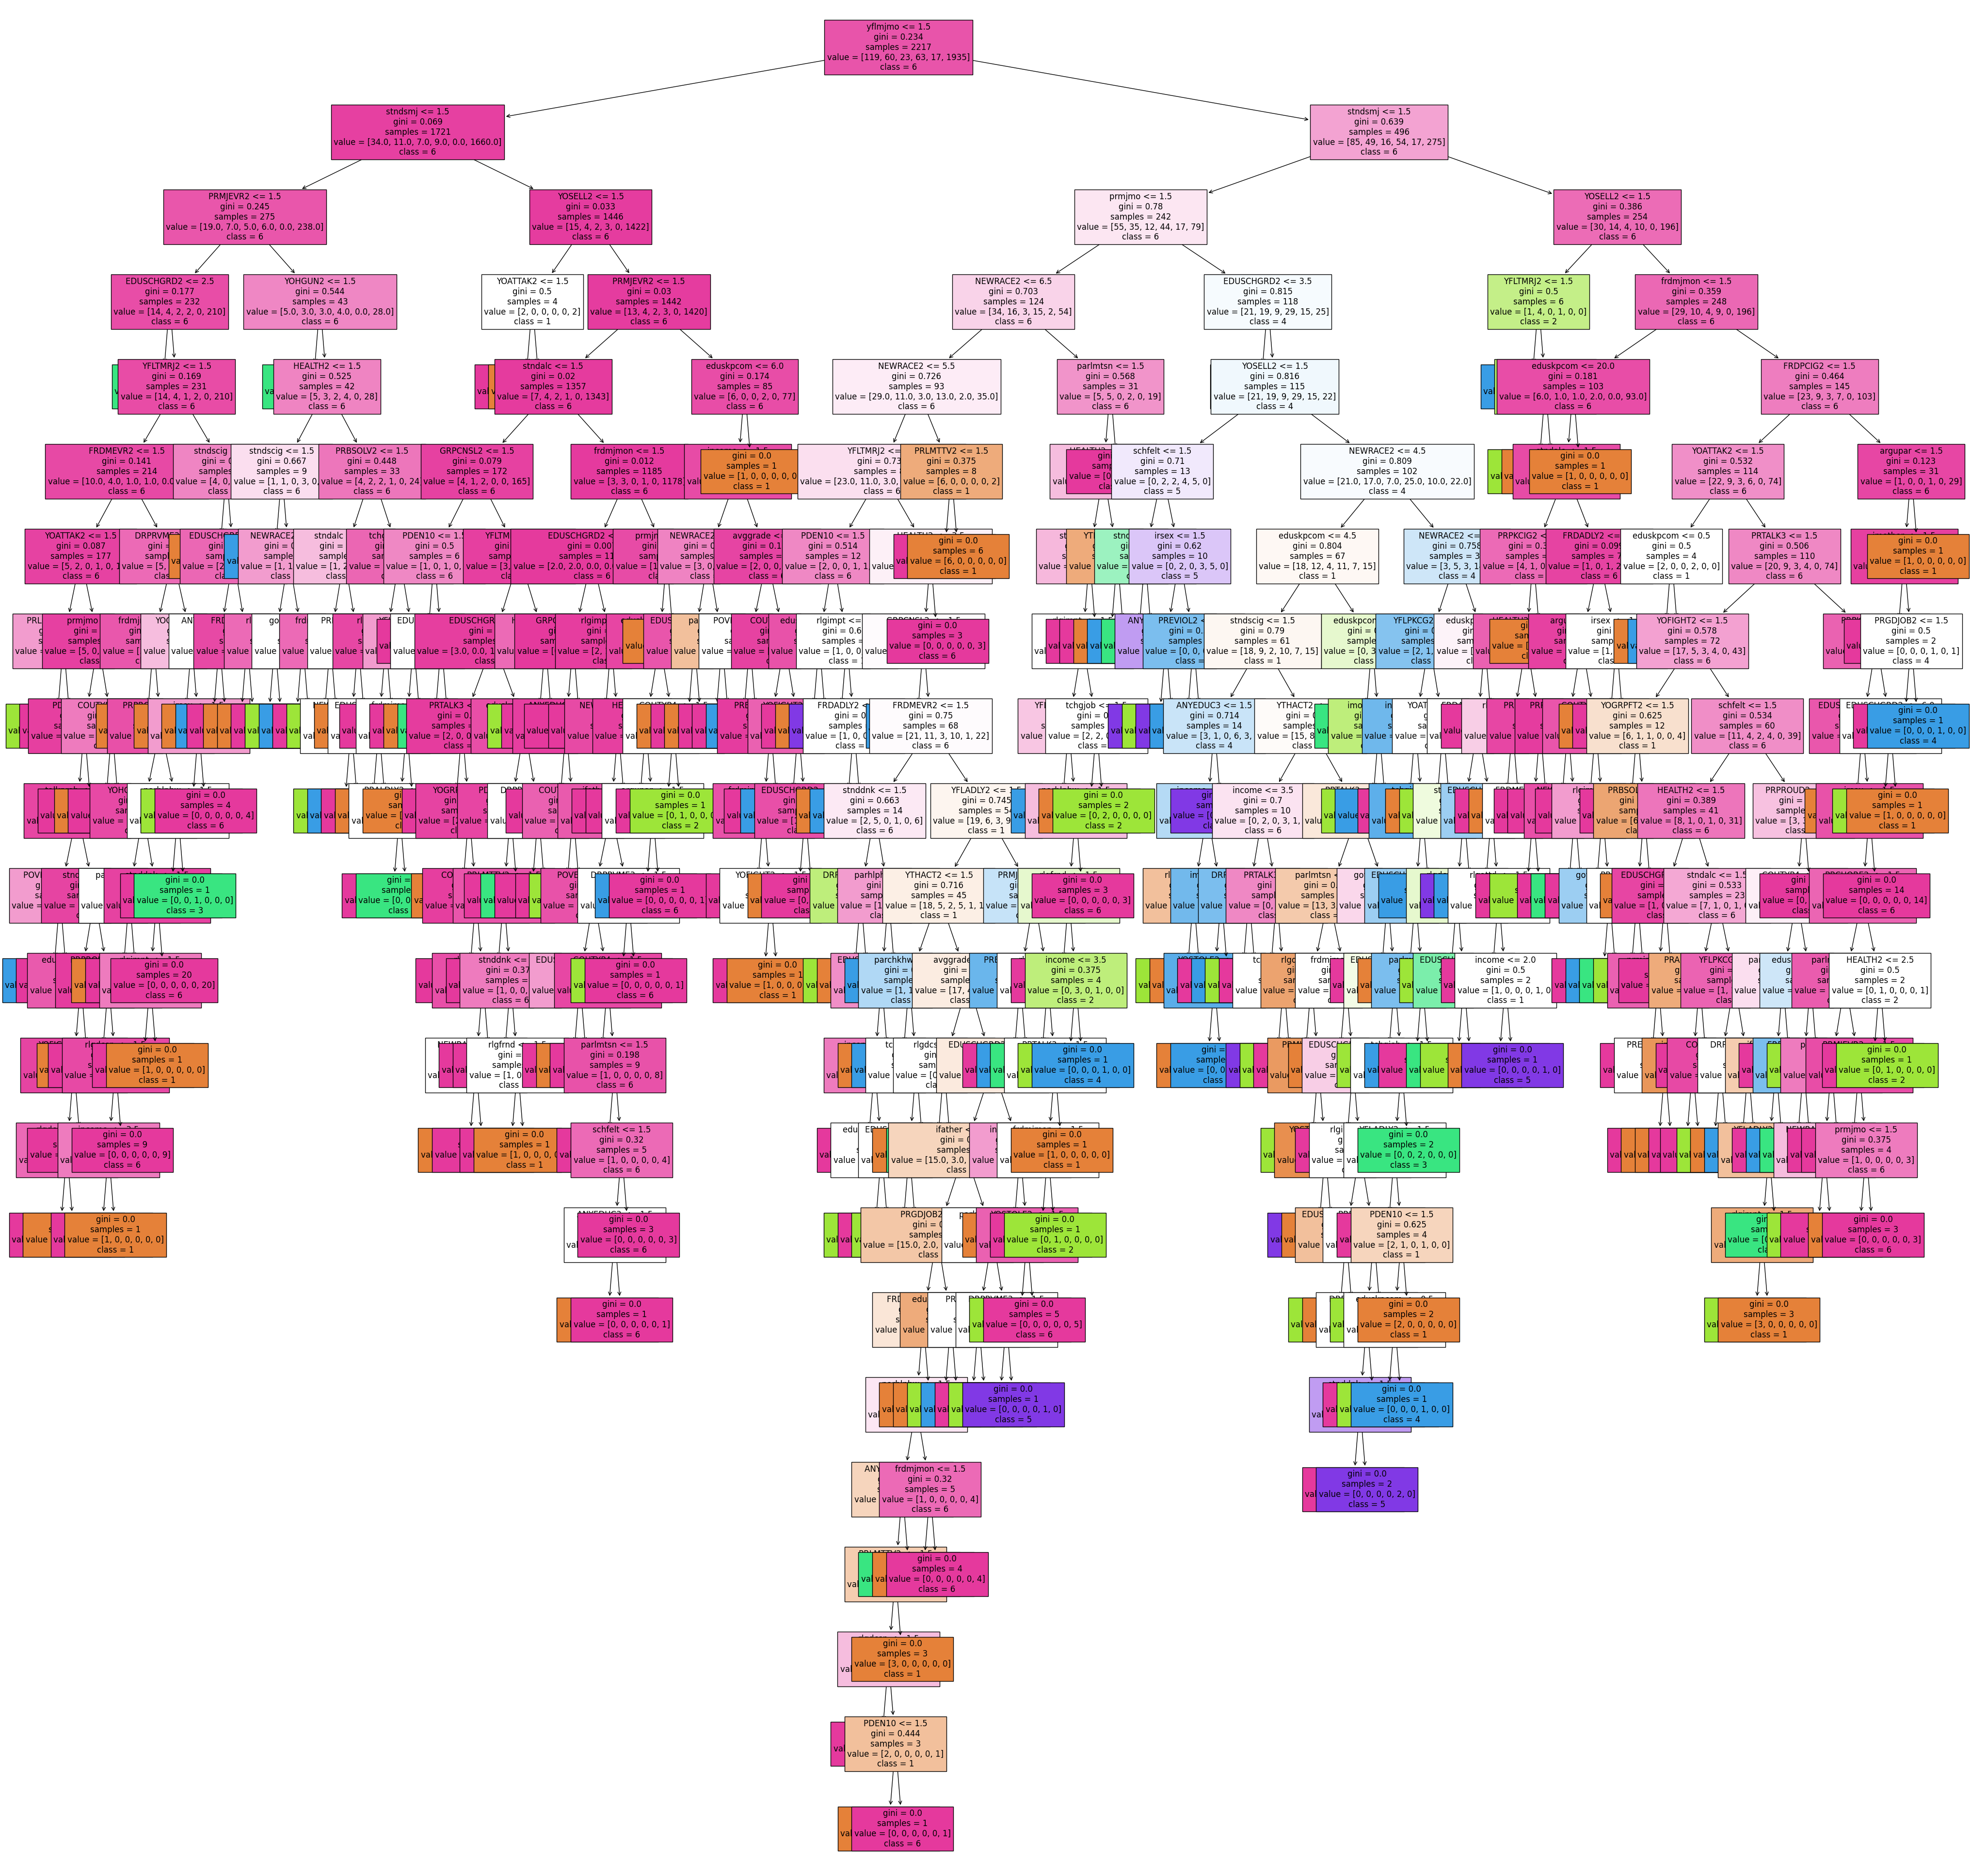

In [15]:
# Plot decision tree
class_names = [str(label) for label in decision_model1.classes_]

# Plot the decision tree
plt.figure(figsize=(50, 50))
plot_tree(decision_model1, filled=True, feature_names=X.columns, class_names=class_names,fontsize=12)
plt.show()



### Pruning:

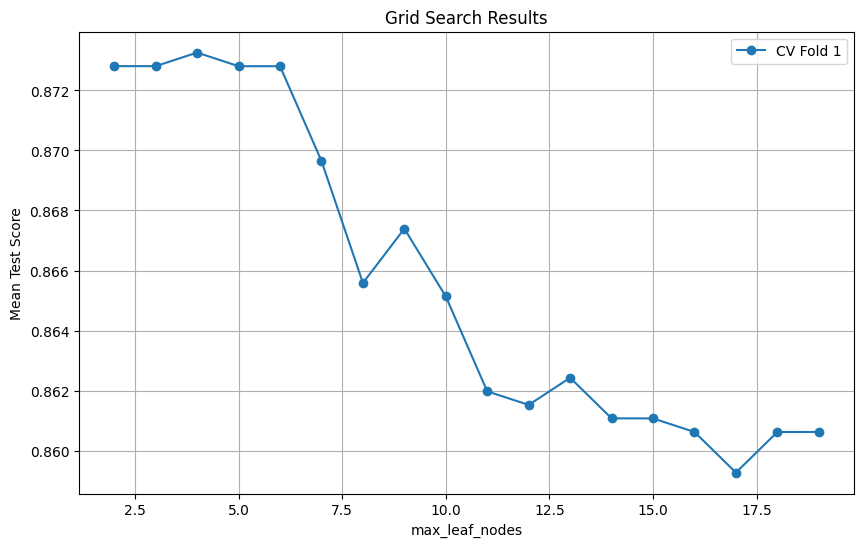

Accuracy: 0.8853838065194533
Test Error: 0.11461619348054675
Top 10 Features:
yflmjmo : 0.6921816163405985
stndsmj : 0.25642589492338674
YOSELL2 : 0.05139248873601483
rlgfrnd : 0.0
avggrade : 0.0


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns 

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_leaf_nodes': range(2, 20)  # Define a range of values for max_leaf_nodes
}

# Initialize the decision tree classifier
decision_model1 = DecisionTreeClassifier(random_state=5)

# Perform GridSearchCV for pruning
grid_search = GridSearchCV(estimator=decision_model1, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Extract the mean test scores from the GridSearchCV results
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Reshape the mean test scores to match the shape of the parameter grid
mean_test_scores = mean_test_scores.reshape(-1, len(param_grid['max_leaf_nodes']))

# Create a heatmap to visualize the mean test scores
plt.figure(figsize=(10, 6))
for fold, scores in enumerate(mean_test_scores):
    plt.plot(param_grid['max_leaf_nodes'], scores, marker='o', label=f'CV Fold {fold + 1}')

plt.title("Grid Search Results")
plt.xlabel("max_leaf_nodes")
plt.ylabel("Mean Test Score")
plt.legend()
plt.grid(True)
plt.show()


# Get the best pruned model
best_pruned_model = grid_search.best_estimator_

# Predict on test data using the best pruned model
predictions1 = best_pruned_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions1)
print("Accuracy:", accuracy)

# Calculate test error
pruned_test_error = 1 - accuracy
print("Test Error:", pruned_test_error)

# Get feature importance scores from the best pruned model
feature_importance = best_pruned_model.feature_importances_

# Sort feature importance scores
sorted_indices = np.argsort(feature_importance)[::-1]
top_10_features = X.columns[sorted_indices][:5]

# Print top 10 features and their importance scores
print("Top 10 Features:")
for feature, importance in zip(top_10_features, feature_importance[sorted_indices][:10]):
    print(feature, ":", importance)


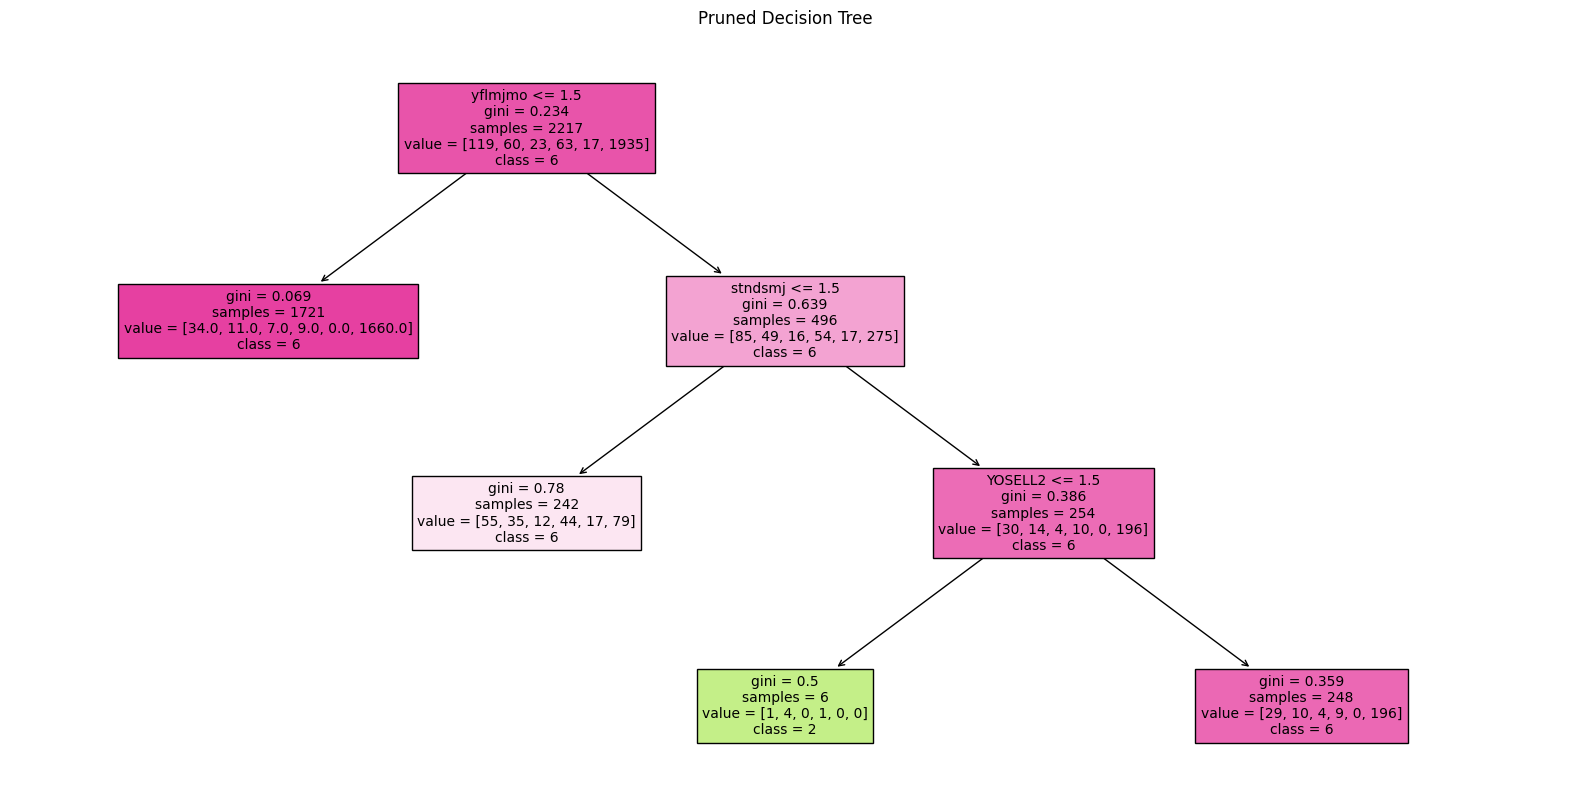

In [17]:
plt.figure(figsize=(20, 10))  # Set the figure size
plot_tree(best_pruned_model, filled=True, feature_names=X.columns, class_names=class_names,fontsize=10)
plt.title("Pruned Decision Tree")
plt.show()


### Bagging:

Test Error: 0.5365615141955836


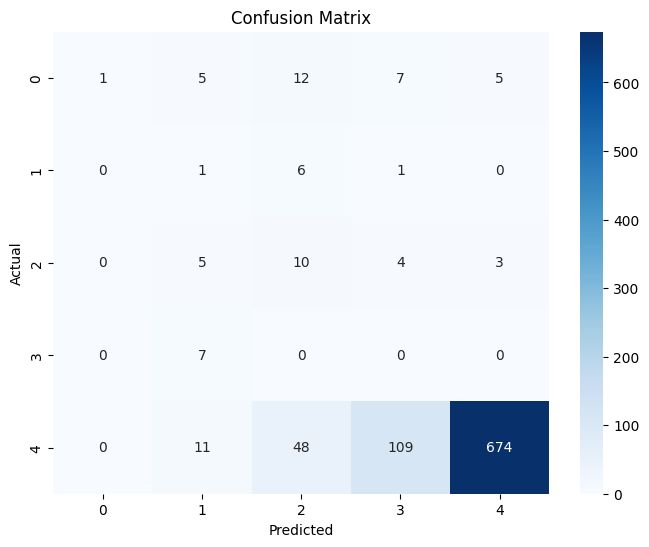

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Set the seed for reproducibility
np.random.seed(5)

# Define the number of variables to sample at each split
mtry_value = len(train_data.columns) - 1

# Initialize the random forest regressor with 500 trees
bagging_model = RandomForestRegressor(n_estimators=500, max_features=mtry_value, random_state=5)

# Fit the model to the training data
bagging_model.fit(X_train, y_train)

# Predict on test data using bagging model
bagging_predictions = bagging_model.predict(X_test)

y_test_numeric = y_test.astype(float)

# Calculate test error
bagging_test_error = np.mean(np.abs(bagging_predictions - y_test_numeric))
print("Test Error:", bagging_test_error)

# Convert predicted values to integers for confusion matrix calculation
bagging_predictions_int = np.round(bagging_predictions).astype(int)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, bagging_predictions_int, labels=np.unique(bagging_predictions_int))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Random Forest 

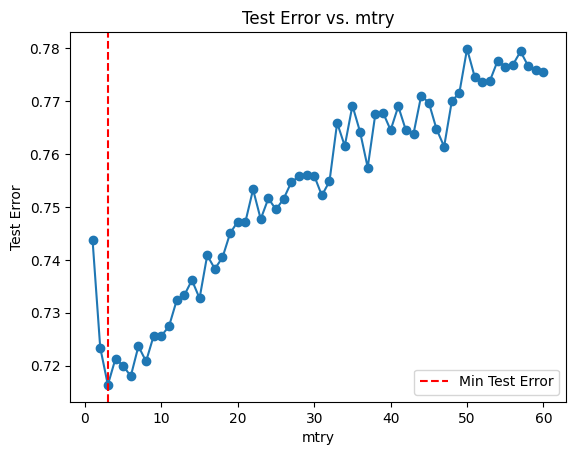

Best value of mtry: 3
Min Test Error: 0.7163426381307497

Top 10 Most Important Features:
yflmjmo : 0.09965714821949233
frdmjmon : 0.06598852695414596
YFLTMRJ2 : 0.05582860233617816
stndsmj : 0.05428863240457501
EDUSCHGRD2 : 0.04730028406246252
HEALTH2 : 0.03331821836068282
FRDMEVR2 : 0.029659028041459163
eduskpcom : 0.02846980667399131
NEWRACE2 : 0.026917072687987927
COUTYP4 : 0.023920708774215423


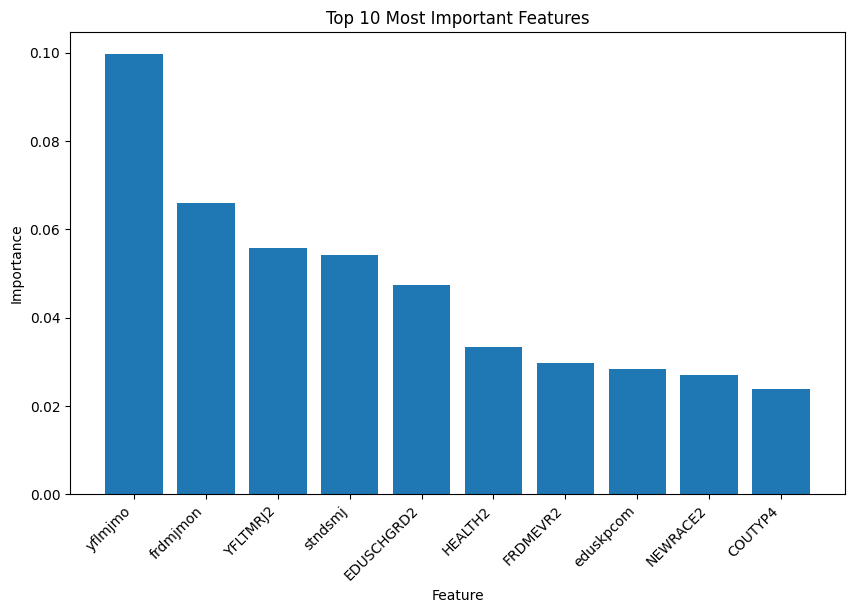

In [19]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# Define a range of values for mtry
p = range(1, X_train.shape[1] + 1)

# Initialize an array to store test errors
errors = []

# Initialize an array to store feature importances
feature_importances = []

# Iterate over each value of mtry
for i in p:
    # Initialize random forest regressor with the current value of mtry
    rf_model = RandomForestRegressor(n_estimators=500, max_features=i, random_state=5)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predict on test data
    rf_predictions = rf_model.predict(X_test)
    
    # Calculate test error (1 - R^2)
    test_error = 1 - rf_model.score(X_test, y_test)
    
    # Append the test error to the errors list
    errors.append(test_error)
    
    # Get feature importances
    feature_importances.append(rf_model.feature_importances_)

# Find the index of the minimum test error
min_error_index = np.argmin(errors)

# Plot the test errors for different values of mtry
plt.plot(p, errors, marker='o')
plt.xlabel('mtry')
plt.ylabel('Test Error')
plt.title('Test Error vs. mtry')
plt.axvline(x=min_error_index + 1, color='red', linestyle='--', label='Min Test Error')
plt.legend()
plt.show()

# Print the best value of mtry and its corresponding test error
best_mtry = min_error_index + 1
print("Best value of mtry:", best_mtry)
print("Min Test Error:", errors[min_error_index])

# Calculate average feature importances
avg_feature_importances = np.mean(feature_importances, axis=0)

# Get the indices of the top 10 most important features
top_10_indices = np.argsort(avg_feature_importances)[::-1][:10]

# Get the names of the top 10 most important features
top_10_features = X.columns[top_10_indices]

# Get the importance scores of the top 10 features
top_10_importances = avg_feature_importances[top_10_indices]

# Print the top 10 most important features and their importance scores
print("\nTop 10 Most Important Features:")
for feature, importance in zip(top_10_features, top_10_importances):
    print(feature, ":", importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_features)), top_10_importances, tick_label=top_10_features)
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

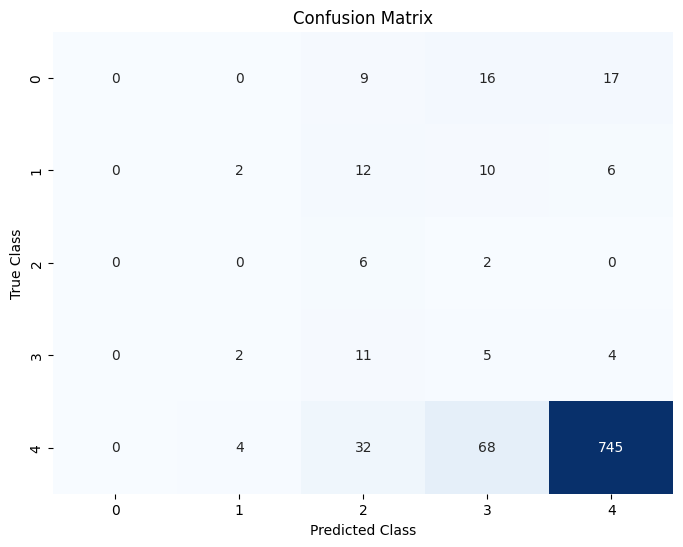

In [20]:
thresholds = [0, 1, 2, 3, 4, 5, np.inf]  # Define thresholds based on your problem

# Discretize predicted values into classes
predicted_classes = np.digitize(rf_predictions, bins=thresholds) - 1  # Subtract 1 to make classes start from 0

# Discretize true values into classes
true_classes = np.digitize(y_test, bins=thresholds) - 1  # Subtract 1 to make classes start from 0

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


### Gradient Boosting

Best shrinkage value: 0.01


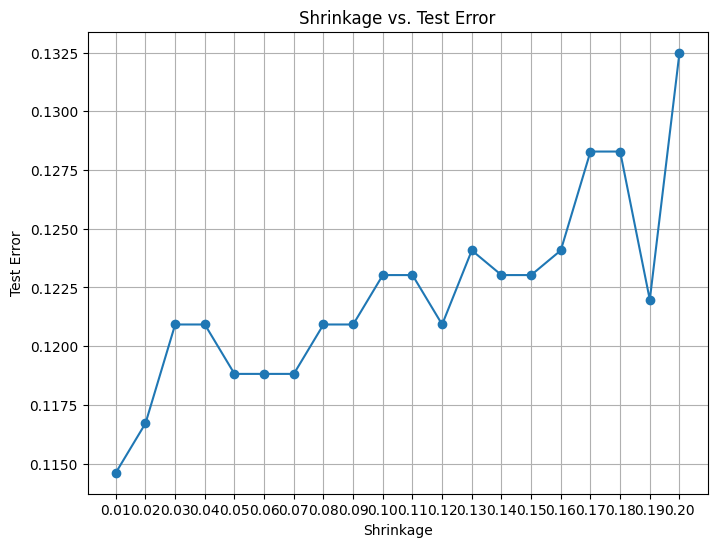

Best model Test Error: 0.11461619348054675


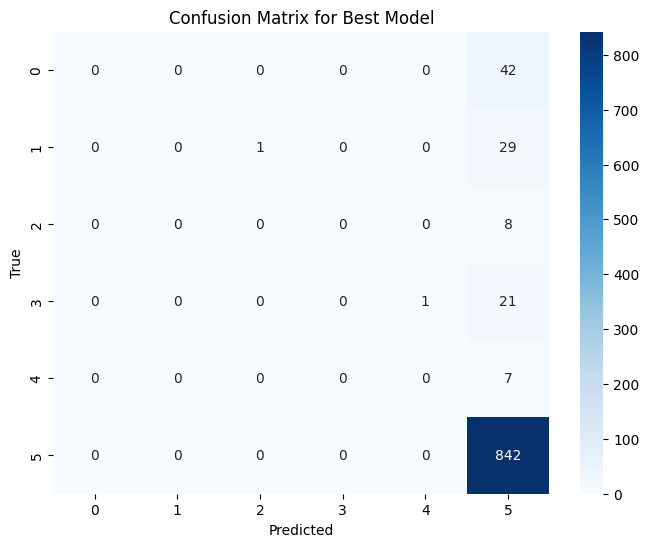

Top 10 Feature Importance:
       Feature  Importance
40     yflmjmo    0.219542
44    frdmjmon    0.200814
17     stndsmj    0.148492
39    YFLTMRJ2    0.068823
31     YOSELL2    0.038698
36      prmjmo    0.030809
4   EDUSCHGRD2    0.027937
5    eduskpcom    0.027349
35    PRMJEVR2    0.018003
43    FRDMEVR2    0.016467


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Define a list of shrinkage values to try
shrinkage_values = np.arange(0.01, 0.21, 0.01).tolist()

# Initialize lists to store results
test_errors = []
confusion_matrices = []

# Iterate over shrinkage values
for shrinkage in shrinkage_values:
    # Train Gradient Boosting model with current shrinkage value
    gb_model = GradientBoostingClassifier(learning_rate=shrinkage, n_estimators=100, subsample=0.8, max_depth=3, random_state=123)
    
    # Fit the model to the training data
    gb_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    test_preds = gb_model.predict(X_test)
    
    # Calculate test error
    accuracy = accuracy_score(y_test, test_preds)
    test_error = 1 - accuracy
    test_errors.append(test_error)
    
    # Calculate confusion matrix
    confusion_matrices.append(confusion_matrix(y_test, test_preds))

# Select the best shrinkage value based on test error
best_shrinkage_idx = test_errors.index(min(test_errors))
best_shrinkage = shrinkage_values[best_shrinkage_idx]
print("Best shrinkage value:", best_shrinkage)

# Plot shrinkage vs. test error
plt.figure(figsize=(8, 6))
plt.plot(shrinkage_values, test_errors, marker='o', linestyle='-')
plt.title('Shrinkage vs. Test Error')
plt.xlabel('Shrinkage')
plt.ylabel('Test Error')
plt.xticks(shrinkage_values)
plt.grid(True)
plt.show()

# Train the Gradient Boosting model with the best shrinkage value
best_gb_model = GradientBoostingClassifier(learning_rate=best_shrinkage, n_estimators=100, subsample=0.8, max_depth=3, random_state=123)
best_gb_model.fit(X_train, y_train)

# Make predictions on the test data
test_preds = best_gb_model.predict(X_test)

# Calculate test error
accuracy = accuracy_score(y_test, test_preds)
best_test_error = 1 - accuracy
print("Best model Test Error:", best_test_error)


conf_matrix = confusion_matrix(y_test, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Extract feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_gb_model.feature_importances_})
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Feature Importance:")
print(top_10_features)

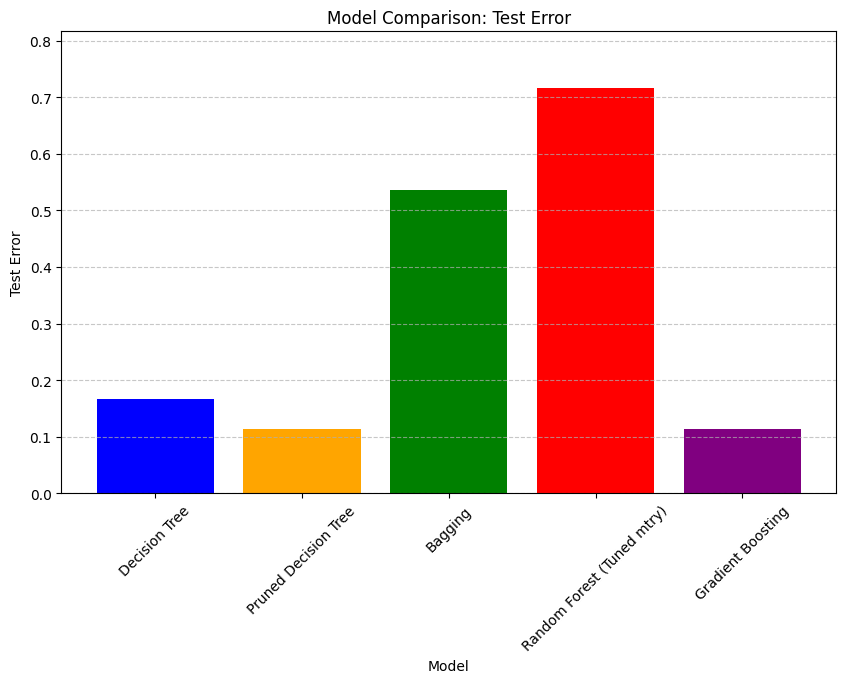

In [22]:
import matplotlib.pyplot as plt

# Test errors of each model
models = ['Decision Tree', 'Pruned Decision Tree', 'Bagging', 'Random Forest (Tuned mtry)', 'Gradient Boosting']
test_errors = [decision_test_error, pruned_test_error, bagging_test_error, errors[min_error_index], best_test_error]

# Plot model comparison
plt.figure(figsize=(10, 6))
plt.bar(models, test_errors, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Model Comparison: Test Error')
plt.xlabel('Model')
plt.ylabel('Test Error')
plt.ylim(0, max(test_errors) + 0.1)  # Adjust ylim for better visualization
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Method 3: Regressor:

In [23]:
# Select relevant columns
df_demog = df[demographic_cols]
df_youth = df.loc[:, 'schfelt':'rlgfrnd']  # Assuming SCHFELT to RLGFRND are the column names
ircigage = df[df['ircigage'] != 991]['ircigage']

#Concatenate the selected data frames horizontally (by columns)
ircigage_data = pd.concat([df_demog, df_youth, ircigage], axis=1)
ircigage_data= ircigage_data.dropna()

# Print the dimensions of the resulting dataset
print(ircigage_data.shape)
ircigage_data

(212, 61)


irsex NEWRACE2 HEALTH2 eduschlgo EDUSCHGRD2  eduskpcom imother ifather  \
2        1        5     2.0         1          4          0       1       1   
9        1        2     3.0         1          5          1       1       2   
30       2        7     3.0         1          6          0       1       1   
33       1        1     2.0         1          4          0       2       1   
60       1        7     2.0         1          7          0       1       1   
...    ...      ...     ...       ...        ...        ...     ...     ...   
3988     2        1     4.0         1          5          0       1       2   
4003     2        1     2.0         1          7          0       1       1   
4004     1        7     2.0         1          6          0       1       2   
4010     2        1     3.0         1          8          2       1       1   
4024     2        1     2.0         1          8          9       1       1   

     income govtprog  ... GRPCNSL2 PREGPGM2 YTHACT2 DRPRVME3 ANYEDUC3 rlgattd  \
2         4        1  ...      2.0      2.0     2.0      1.0      1.0     2.0   
9         1        1  ...      2.0      2.0     1.0      2.0      2.0     2.0   
30        2        2  ...      2.0      2.0     1.0      1.0      1.0     2.0   
33        2        2  ...      2.0      2.0     2.0      1.0      1.0     2.0   
60        4        2  ...      2.0      2.0     1.0      1.0      1.0     2.0   
...     ...      ...  ...      ...      ...     ...      ...      ...     ...   
3988      2        2  ...      2.0      2.0     2.0      2.0      1.0     2.0   
4003      4        2  ...      2.0      2.0     2.0      1.0      1.0     1.0   
4004      4        2  ...      2.0      2.0     1.0      1.0      1.0     2.0   
4010      4        2  ...      2.0      2.0     2.0      1.0      1.0     2.0   
4024      3        2  ...      2.0      2.0     2.0      2.0      1.0     2.0   

     rlgimpt rlgdcsn rlgfrnd ircigage  
2        1.0     1.0     1.0     13.0  
9        1.0     1.0     2.0     13.0  
30       2.0     2.0     1.0     16.0  
33       2.0     2.0     2.0     13.0  
60       1.0     1.0     2.0     13.0  
...      ...     ...     ...      ...  
3988     1.0     1.0     2.0     14.0  
4003     1.0     1.0     2.0     16.0  
4004     1.0     1.0     1.0     14.0  
4010     2.0     2.0     2.0     16.0  
4024     2.0     2.0     2.0     16.0  

[212 rows x 61 columns]

In [24]:
X = ircigage_data.drop(columns=['ircigage'])
y = ircigage_data['ircigage']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


### Decision Tree Regressor:

In [25]:
!pip install plotly

You should consider upgrading via the 'C:\Users\vdalal\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [26]:
import optuna
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function for Decision Tree
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = DecisionTreeRegressor(**params)
    return -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters found by Optuna
best_params = study.best_params

# Train the model using the best hyperparameters
best_model = DecisionTreeRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
deciison_test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE for Decision Tree:", deciison_test_mse)



[I 2024-04-26 18:12:47,595] A new study created in memory with name: no-name-de573d41-79dd-4c3e-8d88-1260d0c033f0
[I 2024-04-26 18:12:47,674] Trial 0 finished with value: 9.264991776315092 and parameters: {'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 9.264991776315092.
[I 2024-04-26 18:12:47,751] Trial 1 finished with value: 8.072753223391254 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 8.072753223391254.
[I 2024-04-26 18:12:47,822] Trial 2 finished with value: 8.263666885350856 and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 1 with value: 8.072753223391254.
[I 2024-04-26 18:12:47,894] Trial 3 finished with value: 8.32066217304759 and parameters: {'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 8.072753223391254.
[I 2024-04-26 18:12:47,965] Trial 4 finished with value: 9.273252008598

Test MSE for Decision Tree: 5.882070330996044


In [27]:

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Extract the top 5 features and their importances
top_feature_indices = indices[:5]
top_feature_names = X.columns[top_feature_indices]
top_feature_importances = importances[top_feature_indices]

# Create a DataFrame to display the top features and their importances
top_features_df = pd.DataFrame({
    'Feature': top_feature_names,
    'Importance': top_feature_importances
})

print("Top 5 important features:")
print(top_features_df)



Top 5 important features:
      Feature  Importance
0  EDUSCHGRD2    0.681859
1    parchkhw    0.148151
2     rlgimpt    0.085391
3     schfelt    0.046335
4    frdmjmon    0.038264


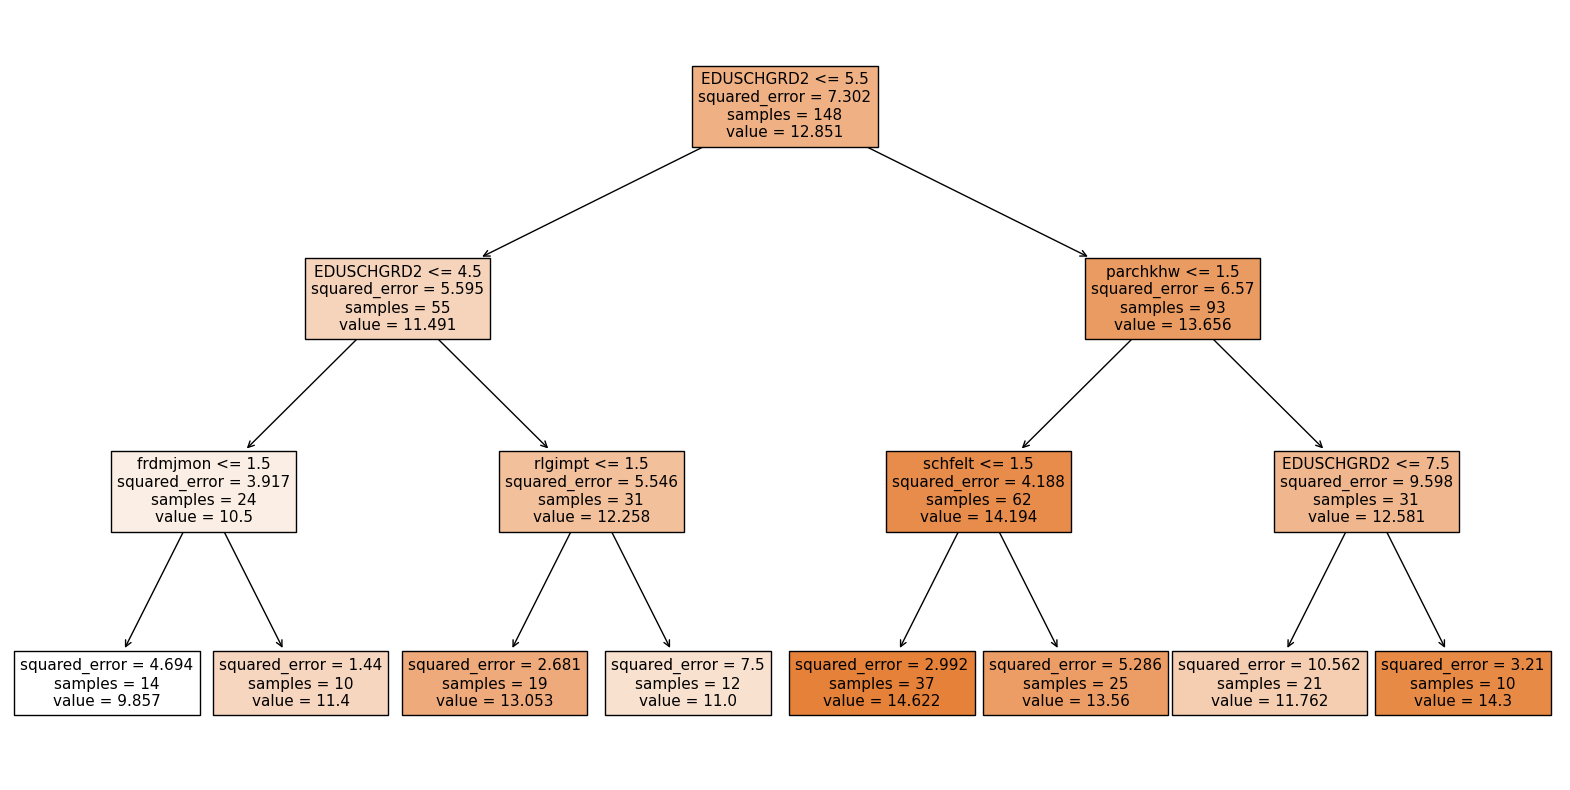

In [28]:
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns)
plt.show()

### Random Forest:

In [29]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Train Random Forest model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate model on validation set
    predictions = model.predict(X_valid)
    mse = mean_squared_error(y_valid, predictions)
    return mse

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Train Random Forest model with best hyperparameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test)
random_test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE:", random_test_mse)

# Get feature importances and sort them
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Extract the top 5 features and their importances
top_feature_indices = indices[:5]
top_feature_names = X.columns[top_feature_indices]
top_feature_importances = importances[top_feature_indices]

# Create a DataFrame to display the top features and their importances
top_features_df = pd.DataFrame({
    'Feature': top_feature_names,
    'Importance': top_feature_importances
})

print("Top 5 important features:")
print(top_features_df)


[I 2024-04-26 18:12:52,744] A new study created in memory with name: no-name-452d95f1-4873-43ac-9483-5cd7d3e68c85
[I 2024-04-26 18:12:52,877] Trial 0 finished with value: 4.607418771214279 and parameters: {'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 4.607418771214279.
[I 2024-04-26 18:12:53,130] Trial 1 finished with value: 4.515627236644103 and parameters: {'n_estimators': 182, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 4.515627236644103.
[I 2024-04-26 18:12:53,308] Trial 2 finished with value: 4.408212235839185 and parameters: {'n_estimators': 115, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 4.408212235839185.
[I 2024-04-26 18:12:53,569] Trial 3 finished with value: 4.254476827243733 and parameters: {'n_estimators': 183, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 3 with value: 4.254476

Best hyperparameters: {'n_estimators': 183, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2}
Test MSE: 5.403056435050511
Top 5 important features:
      Feature  Importance
0  EDUSCHGRD2    0.274993
1    PRCHORE2    0.042195
2     imother    0.037849
3     HEALTH2    0.031656
4     YTHACT2    0.028917


### Gradient Boosting:

In [30]:
import optuna
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function for Gradient Boosting
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = GradientBoostingRegressor(**params)
    return -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters found by Optuna
best_params = study.best_params

# Train the model using the best hyperparameters
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
gradient_test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE for Gradient Boosting:", gradient_test_mse)


[I 2024-04-26 18:13:04,807] A new study created in memory with name: no-name-b9907a6e-fde5-43ce-bcb7-fd7a57c5cbd1
[I 2024-04-26 18:13:05,340] Trial 0 finished with value: 7.8694995845683895 and parameters: {'n_estimators': 103, 'learning_rate': 0.1314137836035159, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.8694995845683895.
[I 2024-04-26 18:13:05,722] Trial 1 finished with value: 6.884452217911163 and parameters: {'n_estimators': 63, 'learning_rate': 0.0597950930628881, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 6.884452217911163.
[I 2024-04-26 18:13:06,476] Trial 2 finished with value: 8.505891635151368 and parameters: {'n_estimators': 145, 'learning_rate': 0.09594527252722686, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 1 with value: 6.884452217911163.
[I 2024-04-26 18:13:07,140] Trial 3 finished with value: 8.063705812151449 and parameters: {'n_esti

Test MSE for Gradient Boosting: 6.588761917095807


In [31]:
# Get feature importances from the best model
feature_importances_gb = best_model.feature_importances_

# Get indices of the top 5 features
top_feature_indices_gb = feature_importances_gb.argsort()[::-1][:5]
-
# Get the names and importance values of the top 5 features
top_features_gb = X.columns[top_feature_indices_gb]
top_feature_values_gb = feature_importances_gb[top_feature_indices_gb]

print("Top 5 features for Gradient Boosting:")
for feature, importance in zip(top_features_gb, top_feature_values_gb):
    print(f"{feature}: {importance}")


Top 5 features for Gradient Boosting:
EDUSCHGRD2: 0.2509661645599478
YOHGUN2: 0.04953409771863416
rlgdcsn: 0.04925583429570245
parchkhw: 0.04904672369026813
schfelt: 0.03698573354624048


### Svr:

In [32]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function for SVR
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.1, 10),
        'epsilon': trial.suggest_loguniform('epsilon', 0.001, 1),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVR(**params)
    return -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters found by Optuna
best_params = study.best_params

# Train the model using the best hyperparameters
best_model = SVR(**best_params)
best_model.fit(X_train, y_train)

# Calculate permutation feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the indices of the top 5 features
top_feature_indices_svr = perm_importance.importances_mean.argsort()[::-1][:5]

# Get the names and importance values of the top 5 features
top_features_svr = X.columns[top_feature_indices_svr]
top_feature_values_svr = perm_importance.importances_mean[top_feature_indices_svr]

print("Top 5 features for SVR:")
for feature, importance in zip(top_features_svr, top_feature_values_svr):
    print(f"{feature}: {importance}")

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
svr_test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE for SVR:", svr_test_mse)


[I 2024-04-26 18:13:29,897] A new study created in memory with name: no-name-284d9f98-66aa-472f-b698-53560a573bd0
C:\Users\vdalal\AppData\Local\Temp\ipykernel_12060\3203133906.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.1, 10),
C:\Users\vdalal\AppData\Local\Temp\ipykernel_12060\3203133906.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'epsilon': trial.suggest_loguniform('epsilon', 0.001, 1),
[I 2024-04-26 18:13:29,979] Trial 0 finished with value: 6.709540081059458 and parameters: {'C': 0.5877923267016095, 'epsilon': 0.06425720882021028, 'kernel': 'rbf'}. Best is trial 0 with value: 6.709540081059458.
C:\Users\vdalal\A

Top 5 features for SVR:
EDUSCHGRD2: 0.4899065739255546
NEWRACE2: 0.06418279475929223
YTHACT2: 0.050376185567498157
COUTYP4: 0.01621145205505363
frdmjmon: 0.013401524348975288
Test MSE for SVR: 5.019061945863068


### Knn:

In [33]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function for KNN
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2)  # Using 1 for Manhattan distance and 2 for Euclidean distance
    }
    model = KNeighborsRegressor(**params)
    return -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters found by Optuna
best_params = study.best_params

# Train the model using the best hyperparameters
best_model = KNeighborsRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = best_model.predict(X_test)
knn_test_mse = mean_squared_error(y_test, test_predictions)
print("Test MSE for KNN:", knn_test_mse)


[I 2024-04-26 18:13:48,917] A new study created in memory with name: no-name-ba6aac9c-501c-4ee3-9e75-786b9cb3da9a
[I 2024-04-26 18:13:49,146] Trial 0 finished with value: 6.666760612258844 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 6.666760612258844.
[I 2024-04-26 18:13:49,227] Trial 1 finished with value: 6.631529619805482 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 6.631529619805482.
[I 2024-04-26 18:13:49,315] Trial 2 finished with value: 6.671454552324596 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 6.631529619805482.
[I 2024-04-26 18:13:49,394] Trial 3 finished with value: 6.930131855912753 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 6.631529619805482.
[I 2024-04-26 18:13:49,472] Trial 4 finished with value: 6.671454552324596 and parameters: {'n_neighbors': 14, 'weights': 'dista

Test MSE for KNN: 6.238811728395062


### Comparision Plot:

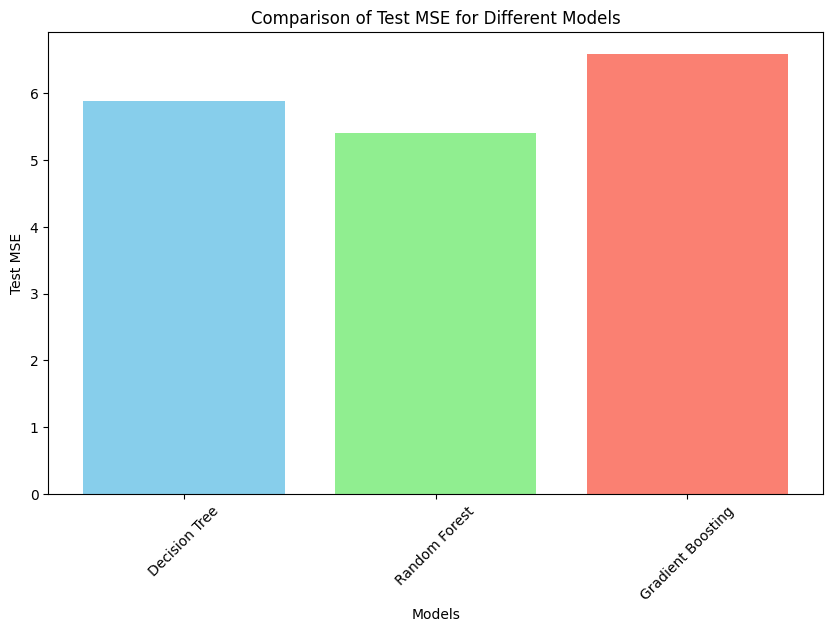

In [35]:
import matplotlib.pyplot as plt

# Define models and their corresponding MSE
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_scores = [deciison_test_mse, random_test_mse, gradient_test_mse]  # Replace with actual MSE values

colors = ['skyblue', 'lightgreen', 'salmon']

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(models, mse_scores, color=colors)
plt.title('Comparison of Test MSE for Different Models')
plt.xlabel('Models')
plt.ylabel('Test MSE')
plt.xticks(rotation=45)
plt.show()
